In [1]:
import pandas as pd
import numpy as np
import random

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolToFile
from rdkit.Chem import MolFromSmiles as mfs
from rdkit.Chem import MolFromSmarts as mfr

from m2p import polymaker

pm = polymaker.PolyMaker()

IPythonConsole.ipython_useSVG = True

RDKit WARNING: [12:41:33] Enabling RDKit 2019.09.3 jupyter extensions
C:\Users\mgirdwoo\AppData\Local\Continuum\anaconda3\envs\my-rdkit-env\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


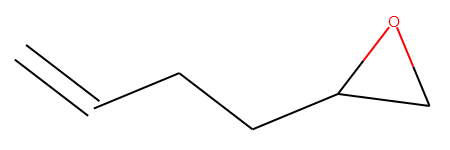

In [7]:
monomer = ("C=CCCC1CO1","C1=CC=C(C=C1)O") 
mola = mfs(monomer[0])
molb = mfs(monomer[1])
mola

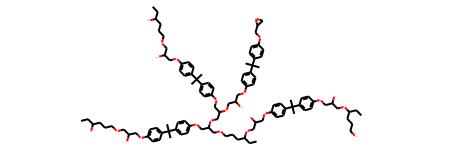

In [2]:
monomer = ("CCC(CCCO)O","C1=CC=C(C=C1)O") 
polymer = pm.polymerize(monomer,mechanism = 'epoxide_ols', DP=8)
mfs(polymer[0])

In [9]:
# smiles recognition code
pm.smiles_req.update({'phenols':' [OH]c1ccccc1'})
pm.smiles_req

{'ols': '[C,c;!$(C=O)][OH]',
 'aliphatic_ols': '[C;!$(C=O);!$([a])][OH]',
 'acids': '[#6][#6](=[#8:4])([F,Cl,Br,I,#8H,O-])',
 'prime_amines': '[#6;!$(C=O)][NH2;!$([NH2+])]',
 'carbonates': '[O]=[C]([F,Cl,Br,I,O])([F,Cl,Br,I,O])',
 'acidanhydrides': '[#8]([#6](=[#8]))([#6](=[#8]))',
 'prime_thiols': '[#6;!$(C=O)][SH]',
 'acrylates': 'OC(=O)C=C',
 'epoxides': '[OX2r3]1[#6r3][#6r3]1',
 'diisocyanates': '[C,c;!$(C=O)]N=C=O',
 'phenols': ' [OH]c1ccccc1'}

# Drawing

('C=CCCC1CO1', 'Oc1ccccc1')


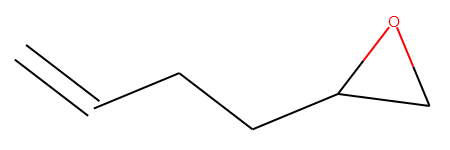

In [10]:
# example of drawing molecules
# for aliphatic test: C(CCCN=C=O)CCN=C=O
# aromatic:C1CC(CCC1CC2CCC(CC2)N=C=O)N=C=O
monomerstring = ("C=CCCC1CO1.C1=CC=C(C=C1)O")   
monomers = pm.get_monomers(monomerstring)
print(monomers)

mola = mfs(monomers[0])
molb = mfs(monomers[1])

# since used the code:
# IPythonConsole.ipython_useSVG = True
# you can just type the variable and it will print the image

mola

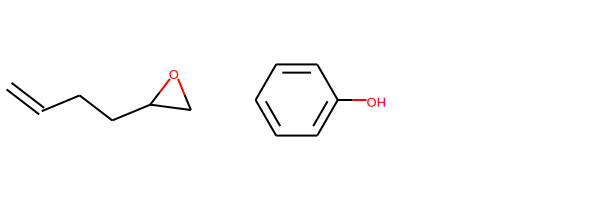

In [11]:
# you can also draw grid, this function requires 
#a list of rdkit mol variables
Draw.MolsToGridImage([mfs(m) for m in monomers])

In [12]:
# to recognize a functional group use the following
# you will have to write your own pattern string
pattern = pm.smiles_req['epoxides']
print(pattern)
mol_pattern = mfr(pattern)
mola = mfs(monomers[0])

# this now identied the atom numbers that match, since there were two acid groups, it is a a tuple
# of two tuples
mola.GetSubstructMatches(mol_pattern)

[OX2r3]1[#6r3][#6r3]1


((6, 5, 4),)

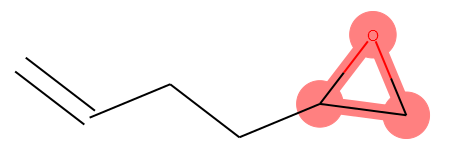

In [13]:
#now the drawing will have it highlighted
mola

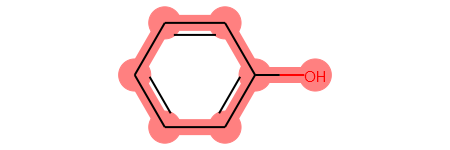

In [14]:
#same thing but for diols
pattern = pm.smiles_req['phenols']
mol_pattern = mfr(pattern)
molb = mfs(monomers[1])
molb.GetSubstructMatches(mol_pattern)
molb

# Reactions

In [ ]:
# this first thing i do is usually check that
# the groups i want to react are correctly coded
# by using the above code to visualize

In [ ]:
# below is the reaction dictionary
rxn_dic = ({'epoxide_phenols':'[OX2r3:1]1[#6r3:3][#6;!$([#6H2]):2]1.[OH:4][c:5]1ccccc1>>'
           '[C:3]([C:2][O:1])[O:5][C:4]'})            #[#6:3](-[#6:2]-[#8:1])-[#8:5]-[#6:4]})

#rxn_dic.update({'epoxide_ols':'[O:1]1[#6:3][#6:2]1.[C,c;!$(C=O):4][OH:5]>>'
           #'[C:3]([C:2][O:1])[O:5][C:4]'})
# first getting the monomers
mola = mfs(monomers[0])
molb = mfs(monomers[1])

# then creating the rxn rule
# i will use the diacid_ols one as its the order of the monomers i wrote above
rxn_string = rxn_dic['epoxide_ols']
rxn = Chem.AllChem.ReactionFromSmarts(rxn_string)

# the running the reaction
# you can see it returns a tuple of reaction products
prod = rxn.RunReactants((mola,molb))
print(prod)

#looking at the structure of each product
Draw.MolsToGridImage([p[0] for p in prod],molsPerRow=2)

# you can see they are all the same.
# the reason is rdkit generates the combinatorial list of all possible products
# so think of it this way, there two diacds which can react with two diols
# that means there are actually 4 possible products9

In [ ]:
# I then turn the products into a list of smiles strings 
# and then makes sure they are valid molecules
prodlist = [Chem.MolToSmiles(x[0]) for x in prod]

prodlist = pm.returnvalid(prodlist)

# from there i randomly choose a product
# if the monomers were asymetric, lets a a Cl on the second carbon
# of the first diacid, i will want to randomly choose the product
# because that Cl will be closer or further away from the diol depending on which diacid
# reacted

poly = random.choice(prodlist)
molpoly = Chem.MolFromSmiles(poly)

molpoly

In [ ]:
# REPEAT! 
try:
    rxn_string = rxn_dic['diisocyanates_aliphatic_ols']
    rxn = Chem.AllChem.ReactionFromSmarts(rxn_string)
    molc = mfs(random.choice(monomers))
    prod = rxn.RunReactants((molc,molpoly))
    prodlist = [Chem.MolToSmiles(x[0]) for x in prod]
    prodlist = pm.returnvalid(prodlist)
    poly = random.choice(prodlist)
    molpoly = Chem.MolFromSmiles(poly)
except:
    rxn_string =  rxn_dic['diisocyanates_aliphatic_ols']
    rxn = Chem.AllChem.ReactionFromSmarts(rxn_string)
    molc = mfs(random.choice(monomers))
    prod = rxn.RunReactants((molc,molpoly))
    prodlist = [Chem.MolToSmiles(x[0]) for x in prod]
    prodlist = pm.returnvalid(prodlist)
    poly = random.choice(prodlist)
    molpoly = Chem.MolFromSmiles(poly)
molpoly

In [ ]:
 rxn_dic['diisocyanates_aliphatic_ols']